In [1]:
folder_path1 = "SpeechAO_AllActors/"
folder_path2 = "SongAO_AllActors/"
folder_path3 = "AudioData/"
folder_path4 = "USC/"

In [2]:
import sys
import os
import subprocess
import xgboost as xgb

In [3]:
def get_wav_file_paths(folder_path):
    return list(map(lambda a: folder_path + str(a).replace("b'", "")[:-1], 
               filter(lambda a: ".wav" in str(a), subprocess.check_output(['ls', folder_path]).splitlines())))

In [4]:
def get_folders(folder_path):
    return [folder_path + str(x).replace("b'", "")[:-1] for x in subprocess.check_output(['ls', folder_path3]).splitlines()]

In [5]:
def get_other_dataset(folder_path):
    folders = get_folders(folder_path)
    fs = []
    for fold in folders:
        fs += get_wav_file_paths(fold + "/")
    return fs

In [16]:
win_s = 512                 # fft size
hop_s = win_s // 4          # hop size

if len(sys.argv) < 2:
    print("Usage: %s <filename> [samplerate]" % sys.argv[0])
    sys.exit(1)

filename = sys.argv[1]

samplerate = 0
if len( sys.argv ) > 2: samplerate = int(sys.argv[2])

s = source(filename, samplerate, hop_s)
samplerate = s.samplerate

pv = pvoc(win_s, hop_s)

f = filterbank(40, win_s)
f.set_mel_coeffs_slaney(samplerate)

energies = zeros((40,))
o = {}

total_frames = 0
downsample = 2

while True:
    samples, read = s()
    fftgrain = pv(samples)
    new_energies = f(fftgrain)
    timestr = '%f' % (total_frames / float(samplerate) )
    print('{:s} {:s}'.format(timestr, ' '.join(['%f' % b for b in new_energies])))
    energies = vstack( [energies, new_energies] )
    total_frames += read
    if read < hop_s: break

ValueError: invalid literal for int() with base 10: '/Users/francescoferrari/Library/Jupyter/runtime/kernel-7e61e7f5-03f8-40cf-9fe3-230f8dfc57af.json'

In [6]:
get_folders(folder_path3)

NameError: name 'get_folders' is not defined

In [6]:
import sys, aubio
import sys
from aubio import source, pvoc, mfcc
from numpy import vstack, zeros, diff
import numpy as np
from aubio import source, pvoc, filterbank



def process_wav_file(filename,
                     samplerate = 0,
                     win_s = 4096,
                     seconds_window = 3,
                     svm = True):
    from aubio import source, pitch

    hop_s = win_s // 4
    #filename = filename.replace("b'", "")[:-1]
    filename = filename.strip()
    
    


    pitches = []
    confidences = []
    #print(filename)
    n_filters = 40              # must be 40 for mfcc
    n_coeffs = 13
    s = source(filename, samplerate, hop_s)
    
    samplerate = s.samplerate

    tolerance = 0.8

    pitch_o = pitch("yin", win_s, hop_s, samplerate)
    pitch_o.set_unit("midi")
    pitch_o.set_tolerance(tolerance)   
    try:
        p = pvoc(win_s, hop_s)
        m = mfcc(win_s, n_filters, n_coeffs, samplerate)
        n_samples = 1#s.duration / s.samplerate / seconds_window
    except TypeError:
        print(filename)
    pv = pvoc(win_s, hop_s)

    f = filterbank(40, win_s)
    f.set_mel_coeffs_slaney(samplerate)

    energies = zeros((40,))
    if n_samples == 0:
        return []
    mfccs = zeros([n_coeffs,])
    frames_read = 0
    while True:
        samples, read = s()
        #print(samples, read)
        spec = p(samples)
        mfcc_out = m(spec)
        mfccs = vstack((mfccs, mfcc_out))
        pitch = pitch_o(samples)[0]
        #pitch = int(round(pitch))
        fftgrain = pv(samples)
        new_energies = f(fftgrain)
        energies = vstack( [energies, new_energies] )
        confidence = pitch_o.get_confidence()
        pitches += [pitch]
        confidences += [confidence]
        frames_read += read
        if read < hop_s: break

    mfccs1 = diff(mfccs, axis = 0)
    mfccs2 = diff(mfccs, axis = 0)
    #print mfccs.shape, mfccs1.shape, mfccs2.shape
    
    


    # total number of fra
    
    
    
    pitches = np.array(pitches)
    pitches = pitches.reshape((len(pitches),1))
#     print(pitches.shape)
#     print(mfccs1.shape)
    
    
    
    
    
    all_data = np.concatenate((mfccs[1:,:], mfccs1, mfccs2, pitches, energies[1:]), 1)
    
    final = []
    size_row = len(all_data) / n_samples
    if svm:
        final.append(get_mean_avg_etc(all_data))
    else:    
        final.append(all_data)
#     for i in range(n_samples):
#         if svm:
#             final.append(get_mean_avg_etc(all_data[i*size_row: (i+1)*size_row]))
#         else:    
#             final.append(all_data[i*size_row: (i+1)*size_row])
    return final
    

In [8]:
process_wav_file("AudioData/DC/a01.wav")

NameError: name 'get_mean_avg_etc' is not defined

In [7]:
d = process_wav_file('/Users/francescoferrari/Downloads/A - Conversation.mp3')

KeyboardInterrupt: 

In [390]:
clfs

[GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=4,
               max_features=None, max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_leaf=0.0,
               n_estimators=100, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False)]

In [391]:
clfs[0].predict(d)

array([3])

In [8]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import scipy.io.wavfile as wav


def process_wav_file_2(filename):
    #filename = filename.replace("b'", "")[:-1]
    print(filename)
    (rate,sig) = wav.read(filename)
    mfcc_feat = mfcc(sig,rate)
    d_mfcc_feat = delta(mfcc_feat, 2)
    dd_mfcc_feat = delta(mfcc_feat, 3)
    fbank_feat = logfbank(sig,rate)
    all_data = np.concatenate((mfcc_feat, d_mfcc_feat, dd_mfcc_feat,fbank_feat), 1)
    final = []
    final.append(get_mean_avg_etc(all_data))
    return final

In [199]:
process_wav_file_2("file.wav")

[[14.154784402833593,
  -3.8647695776343962,
  0.030110363573300096,
  -0.15692018916583134,
  -13.556894421171103,
  25.805934189116957,
  -19.339966896521155,
  18.83733275515868,
  7.3204207663666958,
  3.6580761151357599,
  16.012961151875874,
  -6.5839517817293016,
  12.310803760536874,
  0.00018697115509836535,
  -0.0024146960342088181,
  0.0018308415345986144,
  -0.00055324344441424307,
  -0.0020871686746056751,
  -0.0017955649227387837,
  -0.0012913469280638908,
  0.0012365120399323185,
  -0.0029217644040523561,
  -0.0026936678688825114,
  -0.00038158947305296827,
  -0.0013063645232988469,
  -0.0010385999918074834,
  0.00015948492684504,
  -0.0025570393004484245,
  0.0016248400198420126,
  -0.00033650000864945034,
  -0.0020507432114243952,
  -0.0017690532256026234,
  -0.0018215463506585897,
  0.00060468928853232233,
  -0.0032536833453342935,
  -0.0032640639023175499,
  -0.0013535184496825661,
  -0.0015433120325269083,
  -0.0013588628675107325,
  9.5822322104140714,
  8.46703577

In [7]:
#Speech (1 = neutral, 2 = calm, 3 = happy, 4 = sad, 5 = angry, 6 = fearful, 7 = disgust, 8 = surprised)
#The initial letter(s) of the file name represents the emotion class, and the following digits represent the sentence number.
#The letters 'a', 'd', 'f', 'h', 'n', 'sa' and 'su' represent 'anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness' and 'surprise' emotion classes respectively. 
#E.g., 'd03.wav' is the 3rd disgust sentence. 

# 0 - neutral, 2 - happy 3 - sad 4- angry 

def get_label(filename, svm):
    row = np.zeros(8)|
    if "angry" in filename:
        return 4
    if "happy" in filename:
        return 2
    if "neutral" in filename:
        return 0
    if "sad" in filename:
        return 3
    if len(filename.split("-")) > 3:
        filename = int(filename.split("-")[2])
        if filename == 2:
            filename = 1
        row[filename - 1] = 1
        if svm:
            return filename - 1
        else:
            return row
    else:
        filename = filename.replace(folder_path3, '').replace(".wav", '')
        if "a" in filename:
            return 4
        elif "h" in filename:
            return 2
        elif "n" in filename:
            return 0
        elif "sa" in filename:
            return 3
        else:
            return 5
        

In [8]:
def get_mean_avg_etc(row):
    new_row = []
    new_row += list(row.mean(axis = 0))
    new_row += list(row.std(axis = 0))
    new_row += list(row.min(axis = 0))
    new_row += list(row.max(axis = 0))
    return new_row

In [9]:
get_wav_file_paths(folder_path4)

['USC/4emo_ab_angry_01_001.wav',
 'USC/4emo_ab_angry_02_002.wav',
 'USC/4emo_ab_angry_03_003.wav',
 'USC/4emo_ab_angry_04_004.wav',
 'USC/4emo_ab_angry_05_005.wav',
 'USC/4emo_ab_angry_06_006.wav',
 'USC/4emo_ab_angry_07_007.wav',
 'USC/4emo_ab_angry_08_008.wav',
 'USC/4emo_ab_angry_09_009.wav',
 'USC/4emo_ab_angry_10_010.wav',
 'USC/4emo_ab_angry_11_011.wav',
 'USC/4emo_ab_angry_12_013.wav',
 'USC/4emo_ab_angry_13_014.wav',
 'USC/4emo_ab_angry_14_015.wav',
 'USC/4emo_ab_angry_15_016.wav',
 'USC/4emo_ab_angry_16_017.wav',
 'USC/4emo_ab_angry_17_018.wav',
 'USC/4emo_ab_angry_18_019.wav',
 'USC/4emo_ab_angry_19_020.wav',
 'USC/4emo_ab_angry_20_021.wav',
 'USC/4emo_ab_angry_21_022.wav',
 'USC/4emo_ab_angry_22_024.wav',
 'USC/4emo_ab_angry_23_025.wav',
 'USC/4emo_ab_angry_24_026.wav',
 'USC/4emo_ab_angry_25_027.wav',
 'USC/4emo_ab_angry_26_028.wav',
 'USC/4emo_ab_angry_27_029.wav',
 'USC/4emo_ab_angry_28_030.wav',
 'USC/4emo_ab_angry_29_033.wav',
 'USC/4emo_ab_angry_30_034.wav',
 'USC/4emo

In [40]:
import random 
def make_dataset( svm = True):
    filenames = (get_wav_file_paths(folder_path1) 
                 + get_wav_file_paths(folder_path2) 
                 + get_other_dataset(folder_path3)
                 + get_wav_file_paths(folder_path4))
    np.random.shuffle(filenames)
    y = []
    X = []
    for filename in filenames:
        label = get_label(filename, True)
        if label >= 5:
            continue
        if svm == False and np.argmax(label)>=5:
            continue
        tmp_x = process_wav_file(filename, svm = svm)
        n = len(tmp_x)

        if svm:
            tmp_y = [label, ]*n
        else:
            tmp_y = [list(convert_to_rnn(get_label(filename, True))), ]*n


        X += tmp_x
        y += tmp_y
    return np.array(X), np.array(y)

In [23]:
def convert_to_rnn(label):
    row = np.zeros(4)
    if label == 0:
        row[0] = 1
    else:
        label -=1
        row[label]=1
    return row

In [41]:
X,y = make_dataset(svm=False)

In [27]:
X[0].shape

(320,)

In [245]:
(rate,sig) = wav.read((%s)%"SpeechAO_AllActors/03-01-01-01-01-01-02.wav")

SyntaxError: invalid syntax (<ipython-input-245-0edd8d849063>, line 1)

In [236]:
s = source('SpeechAO_AllActors/03-01-01-01-01-01-23.wav', samplerate, hop_s)

In [240]:
mfcc_feat = mfcc(s.channels(),44000)

TypeError: 'int' object is not callable

In [235]:
sig[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

In [25]:
X.shape, y.shape

((2660, 320), (2660, 4))

In [33]:
from collections import Counter
Counter(y)

Counter({0: 854, 2: 606, 3: 546, 4: 666})

In [23]:
import sklearn.preprocessing
#X = sklearn.preprocessing.normalize(X)

In [24]:
### CLF 1 - SVM

In [25]:
import gensim
import sklearn, sklearn.datasets
import sklearn.naive_bayes, sklearn.linear_model, sklearn.svm, sklearn.neighbors, sklearn.ensemble
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time, re
from sklearn.feature_extraction.text import TfidfVectorizer

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [26]:
from sklearn.metrics import confusion_matrix


def baseline(train_data, train_labels, test_data, test_labels, omit=[]):
    """Train various classifiers to get a baseline."""
    clf, train_accuracy, test_accuracy, train_f1, test_f1, exec_time = [], [], [], [], [], []
    #clf.append(sklearn.neighbors.KNeighborsClassifier(n_neighbors=10))
    #clf.append(sklearn.ensemble.AdaBoostClassifier())
    #clf.append(sklearn.naive_bayes.BernoulliNB(alpha=.01))
    class_weights = {0:0.6, 1:1,2:1,3:1}

    clf.append(sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=5))
    #clf.append(sklearn.naive_bayes.MultinomialNB(alpha=.01))
    clf.append(sklearn.ensemble.GradientBoostingClassifier(max_depth=4, n_estimators=100))
    #clf.append(sklearn.svm.SVC())
    clf.append(sklearn.ensemble.AdaBoostClassifier())
    #clf.append(sklearn.linear_model.RidgeClassifier())
    #clf.append(sklearn.svm.LinearSVC())
    all_preds = []
    all_preds_prob = []
    confusion_matrices = []
    for i,c in enumerate(clf):
        if i not in omit:
            print(c)
            #t_start = time.process_time()
            c.fit(train_data, train_labels)
            train_pred = c.predict(train_data)
            test_pred = c.predict(test_data)
            all_preds.append(test_pred)
            all_preds_prob.append(c.predict_proba(test_data))
            train_accuracy.append('{:5.2f}'.format(100*sklearn.metrics.accuracy_score(train_labels, train_pred)))
            test_accuracy.append('{:5.2f}'.format(100*sklearn.metrics.accuracy_score(test_labels, test_pred)))
            train_f1.append('{:5.2f}'.format(100*sklearn.metrics.f1_score(train_labels, train_pred, average='weighted')))
            test_f1.append('{:5.2f}'.format(100*sklearn.metrics.f1_score(test_labels, test_pred, average='weighted')))
            confusion_matrices.append(confusion_matrix(test_labels, test_pred))
            #exec_time.append('{:5.2f}'.format(time.process_time() - t_start))
    print('Train accuracy:      {}'.format(' '.join(train_accuracy)))
    print('Test accuracy:       {}'.format(' '.join(test_accuracy)))
    print('Train F1 (weighted): {}'.format(' '.join(train_f1)))
    print('Test F1 (weighted):  {}'.format(' '.join(test_f1)))
    return all_preds,all_preds_prob, clf,confusion_matrices
    #print('Execution time:      {}'.format(' '.join(exec_time)))

In [34]:
y = [c if c ==0 else c-1 for c in y]

In [35]:
from collections import Counter
Counter(y)

Counter({0: 854, 1: 606, 2: 546, 3: 666})

In [36]:
limit = int(X.shape[0] / 10 * 8)

In [37]:
#X = (X - X.min(axis = 0)) / X.ptp(axis = 0)

In [38]:
X_train = X[:limit]
y_train = y[:limit]
X_val = X[limit:]
y_val = y[limit:]

In [39]:
X_train

array([[ -1.41836557e+01,   1.28678401e+00,  -2.33431914e-01, ...,
          3.55528414e-01,   3.22741687e-01,   1.46149263e-01],
       [ -2.02463858e+01,   2.18776803e+00,   3.90464486e-01, ...,
          9.61605608e-02,   6.65660128e-02,   4.48897369e-02],
       [ -1.86676698e+01,   1.03346061e+00,  -4.85989765e-01, ...,
          3.92561778e-02,   2.62019448e-02,   2.89179478e-02],
       ..., 
       [ -1.04734345e+01,   3.62437723e+00,   1.97216333e-02, ...,
          2.12822944e-01,   2.08490282e-01,   1.42487466e-01],
       [ -1.36560797e+01,   3.95924126e+00,   8.83066194e-01, ...,
          1.17952943e-01,   1.17252156e-01,   7.65984505e-02],
       [ -4.32021800e+01,   1.33060554e+00,   4.12017518e-01, ...,
          3.17662768e-02,   4.46958207e-02,   5.66233695e-02]])

In [40]:
X_val_T = np.array([X_val[0]])

In [43]:
xg_train = xgb.DMatrix( X_train, label=y_train)
xg_test = xgb.DMatrix(X_val, label=y_val)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 5
param['silent'] = 1
param['nthread'] = 10
param['num_class'] = 4

watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 300
bst = xgb.train(param, xg_train, num_round, watchlist );
# get prediction
pred = bst.predict( xg_test )


print ('predicting, classification error=%f' % (sum( int(pred[i]) != y_val[i] for i in range(len(y_val))) / float(len(y_val)) ))

# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
yprob = bst.predict( xg_test ).reshape( np.array(y_val).shape[0], 4 )
ylabel = np.argmax(yprob, axis=1)

print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != y_val[i] for i in range(len(y_val))) / float(len(y_val)) ))



[0]	train-merror:0.215255	test-merror:0.321495
[1]	train-merror:0.181095	test-merror:0.321495
[2]	train-merror:0.167057	test-merror:0.306542
[3]	train-merror:0.157698	test-merror:0.306542
[4]	train-merror:0.147403	test-merror:0.308411
[5]	train-merror:0.138044	test-merror:0.31215
[6]	train-merror:0.133832	test-merror:0.31028
[7]	train-merror:0.126813	test-merror:0.314019
[8]	train-merror:0.124474	test-merror:0.304673
[9]	train-merror:0.117922	test-merror:0.293458
[10]	train-merror:0.116518	test-merror:0.293458
[11]	train-merror:0.109499	test-merror:0.28785
[12]	train-merror:0.108563	test-merror:0.285981
[13]	train-merror:0.100608	test-merror:0.28785
[14]	train-merror:0.096865	test-merror:0.291589
[15]	train-merror:0.095461	test-merror:0.271028
[16]	train-merror:0.090314	test-merror:0.274766
[17]	train-merror:0.081423	test-merror:0.269159
[18]	train-merror:0.082826	test-merror:0.265421
[19]	train-merror:0.081423	test-merror:0.269159
[20]	train-merror:0.080487	test-merror:0.263551
[21]	t

[187]	train-merror:0	test-merror:0.194393
[188]	train-merror:0	test-merror:0.196262
[189]	train-merror:0	test-merror:0.194393
[190]	train-merror:0	test-merror:0.196262
[191]	train-merror:0	test-merror:0.192523
[192]	train-merror:0	test-merror:0.194393
[193]	train-merror:0	test-merror:0.196262
[194]	train-merror:0	test-merror:0.194393
[195]	train-merror:0	test-merror:0.194393
[196]	train-merror:0	test-merror:0.196262
[197]	train-merror:0	test-merror:0.192523
[198]	train-merror:0	test-merror:0.192523
[199]	train-merror:0	test-merror:0.192523
[200]	train-merror:0	test-merror:0.194393
[201]	train-merror:0	test-merror:0.192523
[202]	train-merror:0	test-merror:0.192523
[203]	train-merror:0	test-merror:0.192523
[204]	train-merror:0	test-merror:0.190654
[205]	train-merror:0	test-merror:0.192523
[206]	train-merror:0	test-merror:0.190654
[207]	train-merror:0	test-merror:0.192523
[208]	train-merror:0	test-merror:0.190654
[209]	train-merror:0	test-merror:0.190654
[210]	train-merror:0	test-merror:0

[72]	train-merror:0.001872	test-merror:0.229907
[73]	train-merror:0.000936	test-merror:0.228037
[74]	train-merror:0.000936	test-merror:0.229907
[75]	train-merror:0.000936	test-merror:0.226168
[76]	train-merror:0.000468	test-merror:0.224299
[77]	train-merror:0.000468	test-merror:0.22243
[78]	train-merror:0.000468	test-merror:0.224299
[79]	train-merror:0	test-merror:0.22243
[80]	train-merror:0	test-merror:0.220561
[81]	train-merror:0	test-merror:0.220561
[82]	train-merror:0	test-merror:0.214953
[83]	train-merror:0	test-merror:0.216822
[84]	train-merror:0	test-merror:0.211215
[85]	train-merror:0	test-merror:0.214953
[86]	train-merror:0	test-merror:0.22243
[87]	train-merror:0	test-merror:0.218692
[88]	train-merror:0	test-merror:0.216822
[89]	train-merror:0	test-merror:0.218692
[90]	train-merror:0	test-merror:0.216822
[91]	train-merror:0	test-merror:0.216822
[92]	train-merror:0	test-merror:0.218692
[93]	train-merror:0	test-merror:0.218692
[94]	train-merror:0	test-merror:0.218692
[95]	train-

[268]	train-merror:0	test-merror:0.190654
[269]	train-merror:0	test-merror:0.190654
[270]	train-merror:0	test-merror:0.190654
[271]	train-merror:0	test-merror:0.190654
[272]	train-merror:0	test-merror:0.190654
[273]	train-merror:0	test-merror:0.190654
[274]	train-merror:0	test-merror:0.192523
[275]	train-merror:0	test-merror:0.190654
[276]	train-merror:0	test-merror:0.190654
[277]	train-merror:0	test-merror:0.190654
[278]	train-merror:0	test-merror:0.190654
[279]	train-merror:0	test-merror:0.190654
[280]	train-merror:0	test-merror:0.188785
[281]	train-merror:0	test-merror:0.190654
[282]	train-merror:0	test-merror:0.188785
[283]	train-merror:0	test-merror:0.188785
[284]	train-merror:0	test-merror:0.188785
[285]	train-merror:0	test-merror:0.188785
[286]	train-merror:0	test-merror:0.188785
[287]	train-merror:0	test-merror:0.188785
[288]	train-merror:0	test-merror:0.190654
[289]	train-merror:0	test-merror:0.190654
[290]	train-merror:0	test-merror:0.188785
[291]	train-merror:0	test-merror:0

In [195]:
[np.argmax(x) for x in yprob]

[0,
 1,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 2,
 1,
 0,
 1,
 0,
 3,
 0,
 1,
 3,
 1,
 2,
 1,
 3,
 1,
 1,
 0,
 2,
 2,
 3,
 3,
 1,
 0,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 1,
 0,
 0,
 1,
 3,
 1,
 0,
 1,
 3,
 3,
 0,
 0,
 3,
 2,
 3,
 2,
 3,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 2,
 0,
 0,
 3,
 3,
 2,
 1,
 3,
 3,
 3,
 2,
 0,
 3,
 1,
 2,
 3,
 0,
 0,
 1,
 3,
 0,
 2,
 3,
 0,
 3,
 0,
 3,
 1,
 1,
 3,
 0,
 0,
 0,
 3,
 3,
 1,
 0,
 1,
 3,
 3,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 3,
 0,
 3,
 0,
 2,
 3,
 2,
 0,
 3,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 3,
 3,
 3,
 3,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 3,
 0,
 1,
 3,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 3,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 3,
 1,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 3,
 0,
 1,
 3,
 2,
 0,
 0,
 3,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 3,
 1,
 3,
 3,
 0,
 3,
 1,
 3,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 3,
 2,
 0,
 2,
 0,
 0,
 3,
 1,
 0,
 0,
 2,
 0,
 3,
 2,
 0,
 1,
 0,
 2,
 0,
 1,


In [35]:
pickle.dump(clfs[1], open("gbt_80_acc.pickle", "wb"))

In [34]:
import pickle
#s = pickle.dumps(clf)
#loaded_model = pickle.load(open("xgboost_75_acc.pickle", "rb"))

In [147]:
loaded_model.predict(xg_test)

array([[  3.64498973e-01,   9.42102342e-04,   7.19679380e-03, ...,
          9.42102342e-04,   9.42102342e-04,   9.42102342e-04],
       [  5.81125123e-03,   5.53583261e-04,   2.23308459e-01, ...,
          5.53583261e-04,   5.53583261e-04,   5.53583261e-04],
       [  3.30561027e-02,   1.39486452e-03,   7.66024888e-01, ...,
          1.39486452e-03,   1.39486452e-03,   1.39486452e-03],
       ..., 
       [  2.09858385e-03,   4.70086001e-04,   1.73958451e-01, ...,
          4.70086001e-04,   4.70086001e-04,   4.70086001e-04],
       [  3.37297842e-03,   6.94337650e-04,   4.72563922e-01, ...,
          6.94337650e-04,   6.94337650e-04,   6.94337650e-04],
       [  4.09611985e-02,   9.70325200e-04,   5.67113101e-01, ...,
          9.70325200e-04,   9.70325200e-04,   9.70325200e-04]], dtype=float32)

In [42]:
t, t_proba, clfs,confusion_matrices = (baseline(X_train, y_train, X_val, y_val))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Train accuracy:      76.13 100.00 56.86
Test accuracy:       6

In [36]:
confusion_matrices[1]

array([[150,   3,  10,   1],
       [  7,  68,   7,  10],
       [ 18,   9,  37,   1],
       [  1,   8,   3,  66]])

In [ ]:
confusion_matrices[1]

In [138]:
from collections import Counter
Counter(y_train)

Counter({0: 452, 2: 310, 3: 301, 4: 290})

In [64]:
rnnX,rnny = make_dataset(folder_path, svm=False)

In [42]:
rnnX = X
rnny = y
limit = int(len(X)/10*8)

In [46]:
rnnX.shape

(2660,)

In [43]:
rnnX_train = rnnX[:limit]
rnny_train = rnny[:limit]
rnnX_val = rnnX[limit:]
rnny_val = rnny[limit:]

In [44]:
rnnX_train[0].shape

(143, 80)

In [1]:
'''Trains a LSTM on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding,TimeDistributed
from keras.layers import LSTM, GRU
from keras.datasets import imdb

max_features = 20000
maxlen = 220  # cut texts after this number of words (among top max_features most common words)
batch_size = 32


y_train = rnny_train
y_test = rnny_val
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(rnnX_train, maxlen=maxlen)
x_test = sequence.pad_sequences(rnnX_val, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


Using TensorFlow backend.


NameError: name 'rnny_train' is not defined

In [2]:
print('Build model...')
model = Sequential()
N = 80
model.add(TimeDistributed(Dense(N), input_shape=(maxlen, N)))
model.add(GRU(output_dim=N,return_sequences=True, dropout=0.2))
model.add(GRU(output_dim=20,return_sequences=True, dropout=0.2))
model.add(GRU(output_dim=10,return_sequences=False, dropout=0.2))
model.add(Dense(4, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Build model...


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=80, return_sequences=True, dropout=0.2)`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=20, return_sequences=True, dropout=0.2)`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(units=10, return_sequences=False, dropout=0.2)`


In [ ]:

print('Train...')
model.fit(x_train, rnny_train,
          batch_size=batch_size,
          epochs=15,
          verbose=1,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

In [3]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [36]:
filename = "SpeechAO_AllActors/03-01-01-01-01-01-01.wav"
samplerate = 0
win_s = 4096
seconds_window = 3
svm = True
hop_s = win_s // 4
#filename = filename.replace("b'", "")[:-1]
#print(filename)
n_filters = 40              # must be 40 for mfcc
n_coeffs = 13
s = source(filename, samplerate, hop_s)
p = pvoc(win_s, hop_s)
m = mfcc(win_s, n_filters, n_coeffs, samplerate)
n_samples = 1#s.duration / s.samplerate / seconds_window

mfccs = zeros([n_coeffs,])
frames_read = 0
while True:
    samples, read = s()
    #print(samples, read)
    spec = p(samples)
    mfcc_out = m(spec)
    mfccs = vstack((mfccs, mfcc_out))
    frames_read += read
    if read < hop_s: break

mfccs1 = diff(mfccs, axis = 0)
mfccs2 = diff(mfccs, axis = 0)
#print mfccs.shape, mfccs1.shape, mfccs2.shape
all_data = np.concatenate((mfccs[1:,:], mfccs1, mfccs1), 1)
    

1024

In [37]:
all_data.shape

(155, 39)

In [34]:
s.duration

158558

In [38]:
1000/25*3

120.0

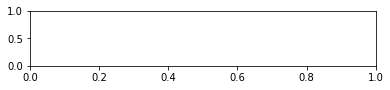

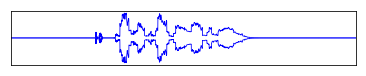

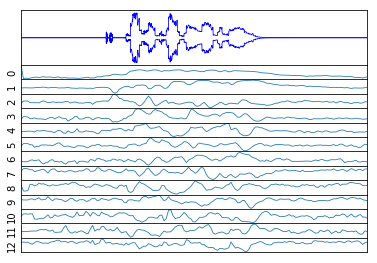

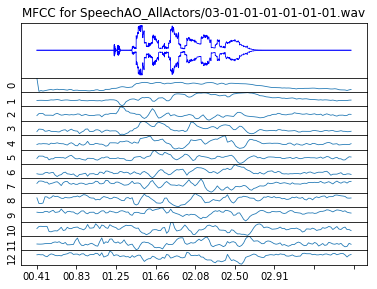

In [42]:
from numpy import arange
from demo_waveform_plot import get_waveform_plot
from demo_waveform_plot import set_xlabels_sample2time
import matplotlib.pyplot as plt

fig = plt.figure()
plt.rc('lines',linewidth='.8')
wave = plt.axes([0.1, 0.75, 0.8, 0.19])
source_filename = filename
get_waveform_plot( source_filename, samplerate, block_size = hop_s, ax = wave)
wave.xaxis.set_visible(False)
wave.yaxis.set_visible(False)
mode="default"
# compute first and second derivatives
if mode in ["delta", "ddelta"]:
    mfccs = diff(mfccs, axis = 0)
if mode == "ddelta":
    mfccs = diff(mfccs, axis = 0)

all_times = arange(mfccs.shape[0]) * hop_s
n_coeffs = mfccs.shape[1]
for i in range(n_coeffs):
    ax = plt.axes ( [0.1, 0.75 - ((i+1) * 0.65 / n_coeffs),  0.8, 0.65 / n_coeffs], sharex = wave )
    ax.xaxis.set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel('%d' % i)
    ax.plot(all_times, mfccs.T[i])

# add time to the last axis
#set_xlabels_sample2time( ax, frames_read, samplerate)

#plt.ylabel('spectral descriptor value')
ax.xaxis.set_visible(True)
title = 'MFCC for %s' % source_filename
if mode == "delta": title = mode + " " + title
elif mode == "ddelta": title = "double-delta" + " " + title
wave.set_title(title)
plt.show()

0.000000 0.000000 0.000000
0.011610 0.000000 0.000000
0.023220 0.000000 0.000000
0.034830 0.000000 0.000000
0.046440 0.000000 0.454736
0.058050 0.000000 0.454736
0.069660 0.000000 0.454736
0.081270 0.000000 0.364039
0.092880 0.000000 0.039020
0.104490 0.000000 0.116643
0.116100 0.000000 0.116643
0.127710 0.000000 0.107179
0.139320 0.000000 0.174376
0.150930 0.000000 0.208985
0.162540 0.000000 0.257785
0.174150 0.000000 0.257785
0.185760 0.000000 0.257785
0.197370 0.000000 0.139061
0.208980 0.000000 0.207373
0.220590 0.000000 0.216986
0.232200 0.000000 0.225091
0.243810 0.000000 0.225091
0.255420 0.000000 0.078313
0.267029 0.000000 0.208925
0.278639 0.000000 0.209345
0.290249 0.000000 0.209345
0.301859 0.000000 0.240287
0.313469 0.000000 0.244379
0.325079 0.000000 0.151586
0.336689 0.000000 0.113118
0.348299 0.000000 0.205189
0.359909 0.000000 0.228757
0.371519 0.000000 0.228757
0.383129 0.000000 0.228757
0.394739 0.000000 0.272802
0.406349 0.000000 0.116200
0.417959 0.000000 0.210309
0

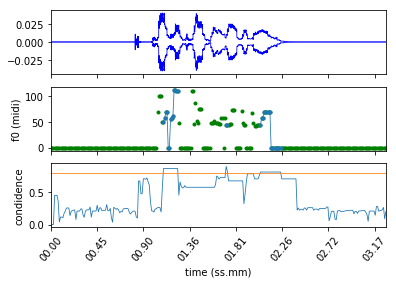

In [109]:
#! /usr/bin/env python

import sys
from aubio import source, pitch




filename = "SpeechAO_AllActors/03-01-01-01-01-01-01.wav"

downsample = 1
samplerate = 44100 // downsample

win_s = 4096 // downsample # fft size
hop_s = 512  // downsample # hop size

s = source(filename, samplerate, hop_s)
samplerate = s.samplerate

tolerance = 0.8

pitch_o = pitch("yin", win_s, hop_s, samplerate)
pitch_o.set_unit("midi")
pitch_o.set_tolerance(tolerance)

pitches = []
confidences = []

# total number of frames read
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    #pitch = int(round(pitch))
    confidence = pitch_o.get_confidence()
    #if confidence < 0.8: pitch = 0.
    print("%f %f %f" % (total_frames / float(samplerate), pitch, confidence))
    pitches += [pitch]
    confidences += [confidence]
    total_frames += read
    if read < hop_s: break

if 0: sys.exit(0)

#print pitches
import os.path
from numpy import array, ma
import matplotlib.pyplot as plt
from demo_waveform_plot import get_waveform_plot, set_xlabels_sample2time

skip = 1

pitches = array(pitches[skip:])
confidences = array(confidences[skip:])
times = [t * hop_s for t in range(len(pitches))]

fig = plt.figure()

ax1 = fig.add_subplot(311)
ax1 = get_waveform_plot(filename, samplerate = samplerate, block_size = hop_s, ax = ax1)
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_xlabel('')

def array_from_text_file(filename, dtype = 'float'):
    filename = os.path.join(os.path.dirname(__file__), filename)
    return array([line.split() for line in open(filename).readlines()],
        dtype = dtype)

ax2 = fig.add_subplot(312, sharex = ax1)
ground_truth = os.path.splitext(filename)[0] + '.f0.Corrected'
if os.path.isfile(ground_truth):
    ground_truth = array_from_text_file(ground_truth)
    true_freqs = ground_truth[:,2]
    true_freqs = ma.masked_where(true_freqs < 2, true_freqs)
    true_times = float(samplerate) * ground_truth[:,0]
    ax2.plot(true_times, true_freqs, 'r')
    ax2.axis( ymin = 0.9 * true_freqs.min(), ymax = 1.1 * true_freqs.max() )
# plot raw pitches
ax2.plot(times, pitches, '.g')
# plot cleaned up pitches
cleaned_pitches = pitches
#cleaned_pitches = ma.masked_where(cleaned_pitches < 0, cleaned_pitches)
#cleaned_pitches = ma.masked_where(cleaned_pitches > 120, cleaned_pitches)
cleaned_pitches = ma.masked_where(confidences < tolerance, cleaned_pitches)
ax2.plot(times, cleaned_pitches, '.-')
#ax2.axis( ymin = 0.9 * cleaned_pitches.min(), ymax = 1.1 * cleaned_pitches.max() )
#ax2.axis( ymin = 55, ymax = 70 )
plt.setp(ax2.get_xticklabels(), visible = False)
ax2.set_ylabel('f0 (midi)')

# plot confidence
ax3 = fig.add_subplot(313, sharex = ax1)
# plot the confidence
ax3.plot(times, confidences)
# draw a line at tolerance
ax3.plot(times, [tolerance]*len(confidences))
ax3.axis( xmin = times[0], xmax = times[-1])
ax3.set_ylabel('condidence')
set_xlabels_sample2time(ax3, times[-1], samplerate)
plt.show()
#plt.savefig(os.path.basename(filename) + '.svg')

